# SAM3 解耦两 Session 分割：Arm（text bootstrap）+ Gripper（标注点）

**设计目标**：消除 arm 与 gripper 分割之间的相互干扰。

## 架构

| | Session 1 — Arm | Session 2 — Gripper |
|---|---|---|
| 初始化方式 | text bootstrap `"robot and cable"` | 仅标注点（JSON） |
| 是否需要标注 | **不需要** | **必须**（来自 JSON） |
| 另一方对象是否存在 | 无 gripper 对象 | 无 arm 对象 |
| 传播方式 | 双向 | 双向 |
| 输出 | `outputs_arm` | `outputs_gripper` |

**Merge 步骤**：`arm_only = dilated_arm AND NOT dilated_gripper`，纯 NumPy，无 SAM3 依赖。

## 与原 notebook 的区别

原 `generate_mask_airexo_data_gripper_points.ipynb`：
- Stage A（arm text bootstrap）→ Stage B（同一 session 注入 gripper）
- gripper 对象写入 arm session 的时序记忆，造成干扰

本 notebook：
- Session 1 完全关闭后，Session 2 才初始化——两者共享零状态
- Merge 逻辑从两个独立 outputs dict 分别读取，不存在 obj_id 混淆

In [1]:
# 初始化

# ============================================================
# Imports
# ============================================================
%load_ext autoreload
%autoreload 2

import json
import os
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image

import sam3
from sam3.model_builder import build_sam3_video_predictor

from mask_pipeline_tools import (
    add_text_prompt,
    apply_prompt_list,
    cleanup_process_group,
    cleanup_resources,
    get_frame_size,
    iter_object_masks_from_frame_output,
    load_video_frames_for_visualization,
    propagate_bidirectional_and_merge,
    validate_and_normalize_prompt_list,
    visualize_outputs,
)
from annotation_ui_tools import (
    create_annotation_store,
    create_annotation_ui,
    load_annotation_prompts_json,
    seed_store_from_prompt_map,
)

plt.rcParams["axes.titlesize"] = 12
plt.rcParams["figure.titlesize"] = 12

# ============================================================
# 配置 — 只需修改此区域
# ============================================================

TASK_NAME = "task_0013"
SCENE_NAME = "scene_0001" 

# 路径
VIDEO_PATH = f"/data/haoxiang/data/airexo2/{TASK_NAME}/train/{SCENE_NAME}/cam_105422061350/color"
CHECKPOINT_PATH = "/data/haoxiang/sam3/models/facebook/sam3/sam3.pt"
# 标注 JSON（gripper 点位）——与原 notebook 共用同一文件
ANNOTATION_JSON_PATH = str(
    Path(VIDEO_PATH).resolve().parent / "annotation_prompts_gripper_points.json"
)

# 推理
CUDA_VISIBLE_DEVICES = "0,1,2,3"
APPLY_TEMPORAL_DISAMBIGUATION = False

# Object IDs
# Session 1：text bootstrap 通常将主对象分配为 obj_id=0。
# 若运行后 warn 提示 obj_id 不匹配，请按提示修改此值。
ARM_OBJ_ID = 0
ARM_OBJ_ID_2 = None  # 双臂模式：设为 int；单臂保持 None

# Session 2：gripper obj_id 须与 JSON 标注文件中的值一致
GRIPPER_LEFT_OBJ_ID = 2
GRIPPER_RIGHT_OBJ_ID = 3

# Session 1 — arm text bootstrap
ARM_TEXT_PROMPT = "robot and cable"
ARM_TEXT_BOOTSTRAP_FRAME_INDEX = 0

# 可视化
VIS_FRAME_STRIDE = 60
VIS_MAX_PLOTS = 8

# 导出
# EXPORT_OUTPUT_DIR = "/data/haoxiang/propainter/masks_airexo_arm_only_decoupled"
EXPORT_OUTPUT_DIR = f"/data/haoxiang/data/airexo2_processed/{TASK_NAME}/{SCENE_NAME}"
EXPORT_DILATE_RADIUS = 15
EXPORT_LOG_EVERY = 50

# ============================================================
# 运行时状态（不需要修改）
# ============================================================
video_frames_for_vis = None
TOTAL_FRAMES = None
IMG_WIDTH = None
IMG_HEIGHT = None

predictor_arm = None
session_id_arm = None
outputs_arm = None

predictor_gripper = None
session_id_gripper = None
outputs_gripper = None

gripper_left_prompts_norm = None
gripper_right_prompts_norm = None

# ============================================================
# 加载视频帧（两个 session 共用）
# ============================================================

# 重复执行时先清理残留 predictor，防止 NCCL 初始化异常
if predictor_arm is not None:
    print("[init] cleaning up previous arm predictor")
    cleanup_resources(predictor_obj=predictor_arm, session_id_value=session_id_arm)
    predictor_arm = None
    session_id_arm = None

if predictor_gripper is not None:
    print("[init] cleaning up previous gripper predictor")
    cleanup_resources(predictor_obj=predictor_gripper, session_id_value=session_id_gripper)
    predictor_gripper = None
    session_id_gripper = None

os.environ["CUDA_VISIBLE_DEVICES"] = CUDA_VISIBLE_DEVICES
print(f"[init] CUDA_VISIBLE_DEVICES={os.environ.get('CUDA_VISIBLE_DEVICES')}")

video_frames_for_vis = load_video_frames_for_visualization(VIDEO_PATH)
TOTAL_FRAMES = len(video_frames_for_vis)
IMG_WIDTH, IMG_HEIGHT = get_frame_size(video_frames_for_vis)

print(f"[init] frames={TOTAL_FRAMES}  size={IMG_WIDTH}x{IMG_HEIGHT}")
print(f"[init] VIDEO_PATH={VIDEO_PATH}")
print(f"[init] ANNOTATION_JSON_PATH={ANNOTATION_JSON_PATH}")

/home/haoxiang/sam3/sam3/model_builder.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


[init] CUDA_VISIBLE_DEVICES=0,1,2,3
[init] frames=353  size=1280x720
[init] VIDEO_PATH=/data/haoxiang/data/airexo2/task_0013/train/scene_0001/cam_105422061350/color
[init] ANNOTATION_JSON_PATH=/data/haoxiang/data/airexo2/task_0013/train/scene_0001/cam_105422061350/annotation_prompts_gripper_points.json


INFO 2026-02-26 18:37:58,233 3114904 sam3_video_predictor.py: 300: using the following GPU IDs: [0, 1, 2, 3]
INFO 2026-02-26 18:37:58,236 3114904 sam3_video_predictor.py: 316: 


	*** START loading model on all ranks ***


INFO 2026-02-26 18:37:58,236 3114904 sam3_video_predictor.py: 318: loading model on rank=0 with world_size=4 -- this could take a while ...


[session1/arm] initializing predictor ...


INFO 2026-02-26 18:38:06,880 3114904 sam3_video_base.py: 125: setting max_num_objects=10000 and num_obj_for_compile=16
INFO 2026-02-26 18:38:10,535 3114904 sam3_video_predictor.py: 320: loading model on rank=0 with world_size=4 -- DONE locally
INFO 2026-02-26 18:38:10,536 3114904 sam3_video_predictor.py: 377: spawning 3 worker processes
/home/haoxiang/sam3/sam3/model_builder.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/home/haoxiang/sam3/sam3/model_builder.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/home/haoxiang/sam3/sam3/model_builder.py

[session1/arm] session started: session_id=5464cad1-7d80-4ddf-af3f-6177375aec68
[session1/arm] text bootstrap: frame=0  prompt='robot and cable'
[session1/arm] add_text_prompt done | frame=0 text='robot and cable'
[session1/arm] propagating (bidirectional) ...


propagate_in_video:   0%|          | 0/353 [00:00<?, ?it/s]

propagate_in_video: 0it [00:00, ?it/s]

[session1/arm] propagation summary | forward_frames=353 backward_frames=0 merged_frames=353
[session1/arm] propagation done: 353 frames
[session1/arm] obj_ids in outputs: [0, 1]
[session1/arm] shutting down predictor ...


INFO 2026-02-26 18:40:07,718 3117396 sam3_video_predictor.py: 251: removed session 5464cad1-7d80-4ddf-af3f-6177375aec68; live sessions: [], GPU memory: 5095 MiB used and 9270 MiB reserved (max over time: 8769 MiB used and 9270 MiB reserved)
INFO 2026-02-26 18:40:07,831 3114904 sam3_video_predictor.py: 251: removed session 5464cad1-7d80-4ddf-af3f-6177375aec68; live sessions: [], GPU memory: 5119 MiB used and 10304 MiB reserved (max over time: 10001 MiB used and 10304 MiB reserved)
INFO 2026-02-26 18:40:07,763 3117395 sam3_video_predictor.py: 251: removed session 5464cad1-7d80-4ddf-af3f-6177375aec68; live sessions: [], GPU memory: 5119 MiB used and 9900 MiB reserved (max over time: 9208 MiB used and 9900 MiB reserved)
INFO 2026-02-26 18:40:07,823 3117397 sam3_video_predictor.py: 251: removed session 5464cad1-7d80-4ddf-af3f-6177375aec68; live sessions: [], GPU memory: 5095 MiB used and 9356 MiB reserved (max over time: 8769 MiB used and 9356 MiB reserved)
INFO 2026-02-26 18:40:07,834 3114

[cleanup] session closed: 5464cad1-7d80-4ddf-af3f-6177375aec68
[cleanup] predictor shutdown finished
[session1/arm] done. outputs_arm preserved (353 frames).


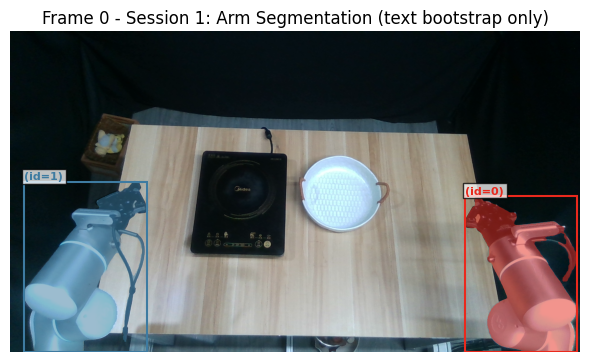

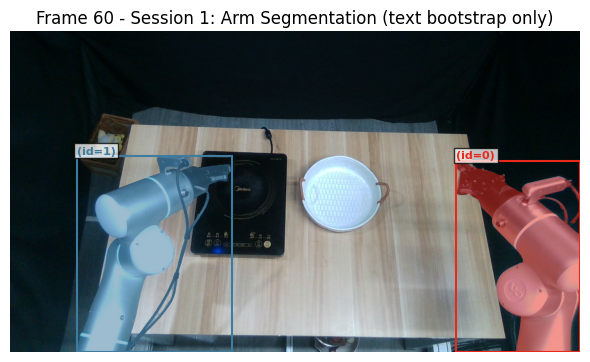

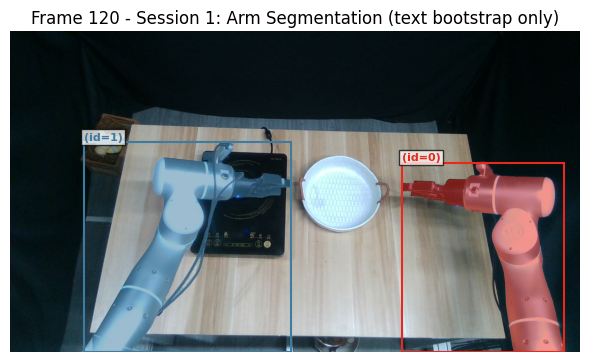

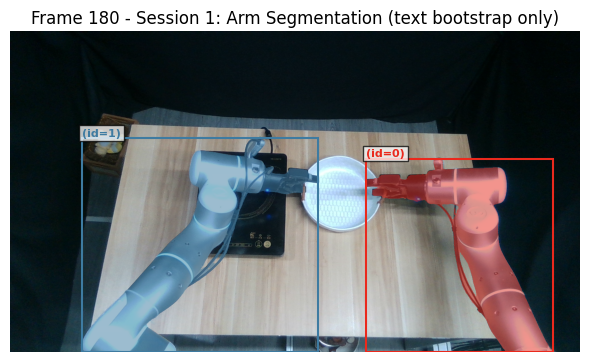

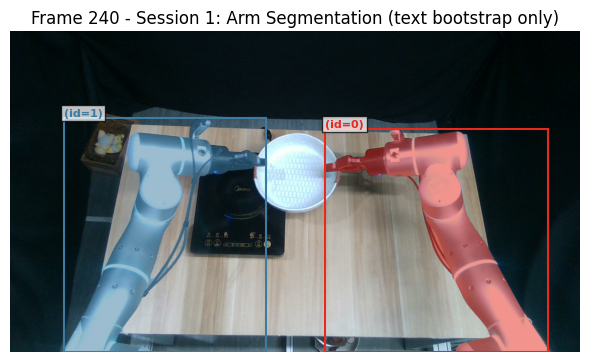

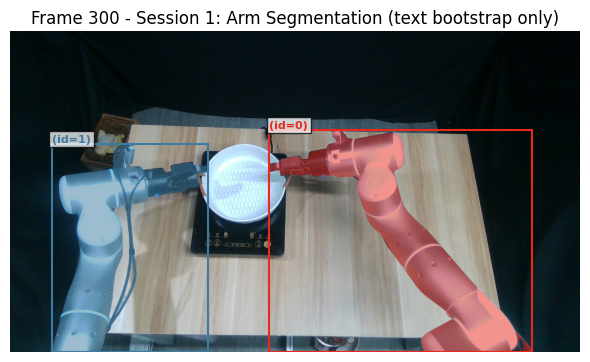

In [2]:
# Session 1 — Arm 分割

# ============================================================
# Session 1 — Arm 分割
# 仅 text bootstrap，无标注点，无 gripper 对象
# ============================================================

print("[session1/arm] initializing predictor ...")
gpus_to_use = range(torch.cuda.device_count())
predictor_arm = build_sam3_video_predictor(
    checkpoint_path=CHECKPOINT_PATH,
    gpus_to_use=gpus_to_use,
    apply_temporal_disambiguation=APPLY_TEMPORAL_DISAMBIGUATION,
)

start_response = predictor_arm.handle_request(
    request=dict(type="start_session", resource_path=VIDEO_PATH)
)
session_id_arm = start_response["session_id"]
print(f"[session1/arm] session started: session_id={session_id_arm}")

# Text bootstrap（无 obj_id 参数，由 SAM3 自动分配）
print(f"[session1/arm] text bootstrap: frame={ARM_TEXT_BOOTSTRAP_FRAME_INDEX}  prompt={ARM_TEXT_PROMPT!r}")
add_text_prompt(
    predictor_obj=predictor_arm,
    session_id_value=session_id_arm,
    frame_index=ARM_TEXT_BOOTSTRAP_FRAME_INDEX,
    text_prompt=ARM_TEXT_PROMPT,
    stage_name="session1/arm",
)

# 双向传播
print("[session1/arm] propagating (bidirectional) ...")
outputs_arm = propagate_bidirectional_and_merge(
    predictor_obj=predictor_arm,
    session_id_value=session_id_arm,
    stage_name="session1/arm",
)
print(f"[session1/arm] propagation done: {len(outputs_arm)} frames")

# 校验 ARM_OBJ_ID 是否出现在输出中
_arm_ids_found = set()
for _fo in outputs_arm.values():
    for _oid, _ in iter_object_masks_from_frame_output(_fo):
        _arm_ids_found.add(int(_oid))
print(f"[session1/arm] obj_ids in outputs: {sorted(_arm_ids_found)}")
if ARM_OBJ_ID not in _arm_ids_found:
    print(
        f"[session1/arm][WARN] ARM_OBJ_ID={ARM_OBJ_ID} not found. "
        f"Found: {sorted(_arm_ids_found)}. "
        f"Please update ARM_OBJ_ID in config to match the actual id."
    )

# 关闭 Session 1；outputs_arm 保留在内存供 Merge 使用
print("[session1/arm] shutting down predictor ...")
cleanup_resources(predictor_obj=predictor_arm, session_id_value=session_id_arm)
predictor_arm = None
session_id_arm = None
print(f"[session1/arm] done. outputs_arm preserved ({len(outputs_arm)} frames).")

# ============================================================
# 可视化 Session 1 arm 结果
# 检查 arm 掩膜质量，若不满意请调整 ARM_TEXT_PROMPT 后重新运行 Session 1
# ============================================================
visualize_outputs(
    outputs_per_frame=outputs_arm,
    video_frames=video_frames_for_vis,
    stride=VIS_FRAME_STRIDE,
    max_plots=VIS_MAX_PLOTS,
    title="Session 1: Arm Segmentation (text bootstrap only)",
)

In [ ]:
# Gripper 标注 UI

# ============================================================
# Gripper 标注 UI
# 在此处为 gripper_left / gripper_right 添加标注点，然后点击 Export 保存 JSON
# 若已有有效 JSON，可跳过此 cell，直接运行下方的 JSON 加载 cell
# ============================================================

# 仅含 gripper 对象，不含 arm（arm 无需标注）
GRIPPER_ANNOTATION_OBJECT_SPECS = {
    "gripper_left": {
        "display": "Gripper Left",
        "obj_id": int(GRIPPER_LEFT_OBJ_ID),
        "target": "GRIPPER_LEFT_KEYFRAME_PROMPTS",
    },
    "gripper_right": {
        "display": "Gripper Right",
        "obj_id": int(GRIPPER_RIGHT_OBJ_ID),
        "target": "GRIPPER_RIGHT_KEYFRAME_PROMPTS",
    },
}

# 若 JSON 已存在，用它 seed UI（不强制加载，仅用于填充初始状态）
_seed_prompt_map = {
    "ARM_CABLE_INITIAL_PROMPTS": [],
    "GRIPPER_LEFT_KEYFRAME_PROMPTS": [],
    "GRIPPER_RIGHT_KEYFRAME_PROMPTS": [],
}
if Path(ANNOTATION_JSON_PATH).exists():
    try:
        _existing = load_annotation_prompts_json(
            json_path=ANNOTATION_JSON_PATH, status_prefix="[annotation/seed]"
        )
        _seed_prompt_map.update(_existing)
        print(f"[annotation] seeding UI from existing JSON: {ANNOTATION_JSON_PATH}")
    except Exception as _e:
        print(f"[annotation][warn] could not seed from JSON: {_e}")

_annotation_store = create_annotation_store(GRIPPER_ANNOTATION_OBJECT_SPECS)
seed_store_from_prompt_map(
    store=_annotation_store,
    object_specs=GRIPPER_ANNOTATION_OBJECT_SPECS,
    prompt_map=_seed_prompt_map,
    img_w=IMG_WIDTH,
    img_h=IMG_HEIGHT,
)

# Export 回调：补齐 ARM_CABLE_INITIAL_PROMPTS 字段后自行保存 JSON。
# 注意：必须用 save_json_on_export=False 禁用 create_annotation_ui 的内部保存，
# 因为内部保存会在添加 ARM 字段之前就调用 validate_export_prompt_map，导致 KeyError。
_gripper_export_result = {}

def _on_gripper_export(export_prompts):
    global _gripper_export_result
    # 补齐 ARM_CABLE_INITIAL_PROMPTS，满足 JSON schema 要求
    _gripper_export_result = {
        "ARM_CABLE_INITIAL_PROMPTS": [],
        "GRIPPER_LEFT_KEYFRAME_PROMPTS": export_prompts.get("GRIPPER_LEFT_KEYFRAME_PROMPTS", []),
        "GRIPPER_RIGHT_KEYFRAME_PROMPTS": export_prompts.get("GRIPPER_RIGHT_KEYFRAME_PROMPTS", []),
    }
    from annotation_ui_tools import save_annotation_prompts_json as _save_json
    _save_json(
        export_prompts=_gripper_export_result,
        json_path=ANNOTATION_JSON_PATH,
        status_prefix="[annotation/gripper]",
    )
    print(f"[annotation] saved to {ANNOTATION_JSON_PATH}")

_annotation_ui = create_annotation_ui(
    video_frames_for_vis=video_frames_for_vis,
    total_frames=TOTAL_FRAMES,
    img_width=IMG_WIDTH,
    img_height=IMG_HEIGHT,
    object_specs=GRIPPER_ANNOTATION_OBJECT_SPECS,
    annotation_store=_annotation_store,
    on_export=_on_gripper_export,
    auto_display=True,
    status_prefix="[annotation/gripper]",
    export_json_path=ANNOTATION_JSON_PATH,
    save_json_on_export=False,  # 禁用内部保存，由 _on_gripper_export 回调负责
)

if not _annotation_ui.get("widget_ready", False):
    print(f"[annotation][fallback] Widget not available: {_annotation_ui.get('widget_error')}")
    print(f"[annotation][fallback] 请直接编辑 JSON 文件: {ANNOTATION_JSON_PATH}")

INFO 2026-02-26 18:42:36,976 3114904 sam3_video_predictor.py: 300: using the following GPU IDs: [0, 1, 2, 3]
INFO 2026-02-26 18:42:36,979 3114904 sam3_video_predictor.py: 316: 


	*** START loading model on all ranks ***


INFO 2026-02-26 18:42:36,979 3114904 sam3_video_predictor.py: 318: loading model on rank=0 with world_size=4 -- this could take a while ...


[session2/gripper] loading annotation from JSON: /data/haoxiang/data/airexo2/task_0013/train/scene_0001/cam_105422061350/annotation_prompts_gripper_points.json
[session2/gripper] JSON 读取成功: /data/haoxiang/data/airexo2/task_0013/train/scene_0001/cam_105422061350/annotation_prompts_gripper_points.json
[session2/gripper] JSON created_at_utc: 2026-02-26T09:34:56.902719+00:00
[session2/gripper] 对象条目统计: {'ARM_CABLE_INITIAL_PROMPTS': 0, 'GRIPPER_LEFT_KEYFRAME_PROMPTS': 2, 'GRIPPER_RIGHT_KEYFRAME_PROMPTS': 2, 'ARM_CABLE_2_INITIAL_PROMPTS': 0}
[session2/gripper] 对象点数统计: {'ARM_CABLE_INITIAL_PROMPTS': 0, 'GRIPPER_LEFT_KEYFRAME_PROMPTS': 4, 'GRIPPER_RIGHT_KEYFRAME_PROMPTS': 4, 'ARM_CABLE_2_INITIAL_PROMPTS': 0}
[session2/gripper] 按对象逐帧点数统计: {'ARM_CABLE_INITIAL_PROMPTS': {}, 'GRIPPER_LEFT_KEYFRAME_PROMPTS': {0: 2, 120: 2}, 'GRIPPER_RIGHT_KEYFRAME_PROMPTS': {0: 2, 120: 2}, 'ARM_CABLE_2_INITIAL_PROMPTS': {}}
[session2/gripper] 含标注帧数: 2
[session2/gripper] left  prompt entries=2  keyframes=[0, 120]
[ses

INFO 2026-02-26 18:42:45,185 3114904 sam3_video_base.py: 125: setting max_num_objects=10000 and num_obj_for_compile=16
INFO 2026-02-26 18:42:48,437 3114904 sam3_video_predictor.py: 320: loading model on rank=0 with world_size=4 -- DONE locally
INFO 2026-02-26 18:42:48,438 3114904 sam3_video_predictor.py: 377: spawning 3 worker processes
/home/haoxiang/sam3/sam3/model_builder.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/home/haoxiang/sam3/sam3/model_builder.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/home/haoxiang/sam3/sam3/model_builder.py

[session2/gripper] session started: session_id=22181365-be46-4b0e-a725-d06376f3c0ed
[session2/gripper] bootstrapping cache: frame=0  prompt='robot and cable'
[session2/bootstrap] add_text_prompt done | frame=0 text='robot and cable'
[session2/gripper] propagating to fill cache (bootstrap pass) ...


propagate_in_video:   0%|          | 0/353 [00:00<?, ?it/s]

propagate_in_video: 0it [00:00, ?it/s]

[session2/bootstrap] propagation summary | forward_frames=353 backward_frames=0 merged_frames=353
[session2/gripper] cache populated (353 frames)
[session2/gripper] applying 2 left gripper prompt entries ...
[session2/gripper_left] add_prompt done | frame=0 obj_id=2 points=2
[session2/gripper_left] add_prompt done | frame=120 obj_id=2 points=2
[session2/gripper] applying 2 right gripper prompt entries ...
[session2/gripper_right] add_prompt done | frame=0 obj_id=3 points=2
[session2/gripper_right] add_prompt done | frame=120 obj_id=3 points=2
[session2/gripper] final propagation (bidirectional) ...


  0%|          | 0/353 [00:00<?, ?it/s]

  0%|          | 0/353 [00:00<?, ?it/s]

100%|██████████| 353/353 [00:17<00:00, 19.75it/s]
0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
INFO 2026-02-26 18:45:11,722 3123511 sam3_video_predictor.py: 251: removed session 22181365-be46-4b0e-a725-d06376f3c0ed; live sessions: [], GPU memory: 5119 MiB used and 11694 MiB reserved (max over time: 10974 MiB used and 11694 MiB reserved)
INFO 2026-02-26 18:45:11,808 3123510 sam3_video_predictor.py: 251: removed session 22181365-be46-4b0e-a725-d06376f3c0ed; live sessions: [], GPU memory: 5119 MiB used and 11734 MiB reserved (max over time: 10976 MiB used and 11734 MiB reserved)
INFO 2026-02-26 18:45:11,838 3114904 sam3_video_predictor.py: 251: removed session 22181365-be46-4b0e-a725-d06376f3c0ed; live sessions: [], GPU memory: 6654 MiB used and 14610 MiB reserved (max over time: 13639 MiB used and 14610 MiB reserved)


[session2/gripper] propagation summary | forward_frames=353 backward_frames=0 merged_frames=353
[session2/gripper] propagation done: 353 frames
[session2/gripper] obj_ids in outputs: [0, 1, 2, 3]
[session2/gripper] shutting down predictor ...


INFO 2026-02-26 18:45:11,849 3123509 sam3_video_predictor.py: 251: removed session 22181365-be46-4b0e-a725-d06376f3c0ed; live sessions: [], GPU memory: 5119 MiB used and 11720 MiB reserved (max over time: 11091 MiB used and 11720 MiB reserved)
INFO 2026-02-26 18:45:11,849 3114904 sam3_video_predictor.py: 513: shutting down 3 worker processes
INFO 2026-02-26 18:45:11,851 3123509 sam3_video_predictor.py: 485: worker rank=1 shutting down
INFO 2026-02-26 18:45:11,851 3123510 sam3_video_predictor.py: 485: worker rank=2 shutting down
INFO 2026-02-26 18:45:11,851 3123511 sam3_video_predictor.py: 485: worker rank=3 shutting down


[cleanup] session closed: 22181365-be46-4b0e-a725-d06376f3c0ed


INFO 2026-02-26 18:45:12,303 3114904 sam3_video_predictor.py: 519: shut down 3 worker processes


[cleanup] predictor shutdown finished
[session2/gripper] done. outputs_gripper preserved (353 frames).


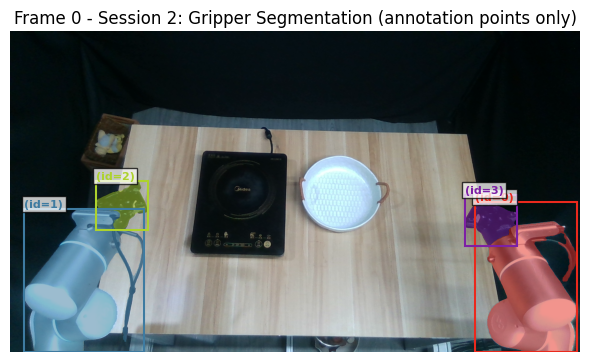

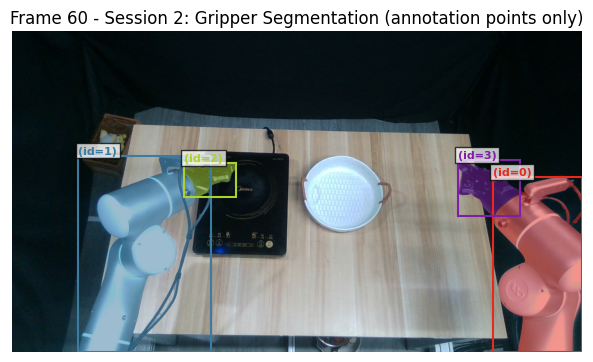

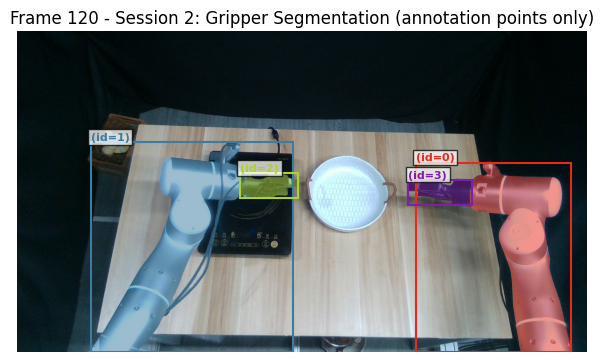

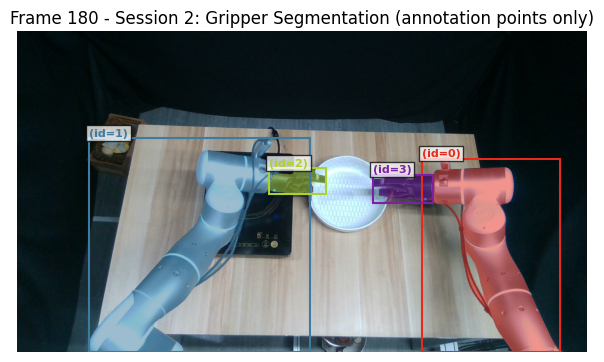

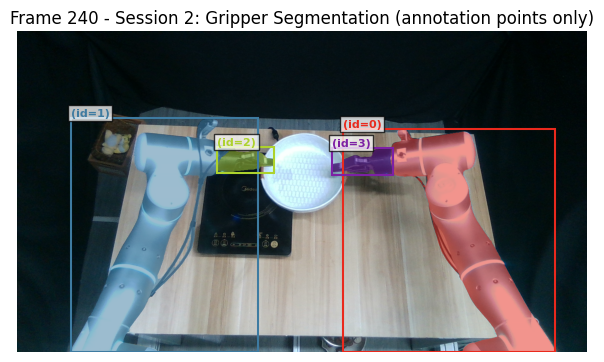

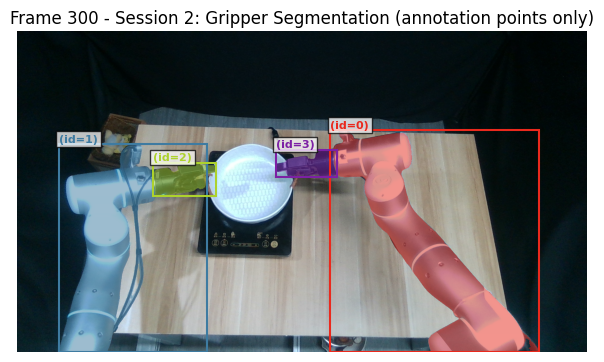

In [3]:
# Gripper 分割

# ============================================================
# 从 JSON 加载并校验 Gripper 标注
# 运行此 cell 前请确认已通过标注 UI 导出 JSON（或手动编辑好 JSON）
# ============================================================

print(f"[session2/gripper] loading annotation from JSON: {ANNOTATION_JSON_PATH}")

try:
    annotation_prompts = load_annotation_prompts_json(
        json_path=ANNOTATION_JSON_PATH, status_prefix="[session2/gripper]"
    )
except FileNotFoundError as _e:
    raise RuntimeError(
        f"[session2/gripper][FATAL] JSON not found: {ANNOTATION_JSON_PATH}\n"
        "请先在标注 UI 中点击 Export Prompts 导出 JSON。"
    ) from _e
except Exception as _e:
    raise RuntimeError(f"[session2/gripper][FATAL] 读取 JSON 失败: {_e}") from _e

gripper_left_prompts_norm = validate_and_normalize_prompt_list(
    annotation_prompts.get("GRIPPER_LEFT_KEYFRAME_PROMPTS", []),
    total_frames=TOTAL_FRAMES,
    img_w=IMG_WIDTH,
    img_h=IMG_HEIGHT,
    tag="GRIPPER_LEFT_KEYFRAME_PROMPTS",
    allow_empty=True,
)
gripper_right_prompts_norm = validate_and_normalize_prompt_list(
    annotation_prompts.get("GRIPPER_RIGHT_KEYFRAME_PROMPTS", []),
    total_frames=TOTAL_FRAMES,
    img_w=IMG_WIDTH,
    img_h=IMG_HEIGHT,
    tag="GRIPPER_RIGHT_KEYFRAME_PROMPTS",
    allow_empty=True,
)

# 至少一侧必须有标注
if len(gripper_left_prompts_norm) == 0 and len(gripper_right_prompts_norm) == 0:
    raise RuntimeError(
        "[session2/gripper][FATAL] GRIPPER_LEFT 和 GRIPPER_RIGHT 均无标注点。\n"
        "请在标注 UI 中为至少一侧 gripper 添加点位并重新导出。"
    )

# 校验 obj_id 与配置一致
for _p in gripper_left_prompts_norm:
    if _p["obj_id"] != GRIPPER_LEFT_OBJ_ID:
        raise ValueError(
            f"[session2/gripper] GRIPPER_LEFT prompt obj_id={_p['obj_id']} "
            f"!= GRIPPER_LEFT_OBJ_ID={GRIPPER_LEFT_OBJ_ID}。请检查 JSON 或配置。"
        )
for _p in gripper_right_prompts_norm:
    if _p["obj_id"] != GRIPPER_RIGHT_OBJ_ID:
        raise ValueError(
            f"[session2/gripper] GRIPPER_RIGHT prompt obj_id={_p['obj_id']} "
            f"!= GRIPPER_RIGHT_OBJ_ID={GRIPPER_RIGHT_OBJ_ID}。请检查 JSON 或配置。"
        )

_left_frames = sorted({p["frame_index"] for p in gripper_left_prompts_norm})
_right_frames = sorted({p["frame_index"] for p in gripper_right_prompts_norm})
print(f"[session2/gripper] left  prompt entries={len(gripper_left_prompts_norm)}  keyframes={_left_frames}")
print(f"[session2/gripper] right prompt entries={len(gripper_right_prompts_norm)}  keyframes={_right_frames}")
print("[session2/gripper] validation passed. Ready for Session 2.")

# ============================================================
# Session 2 — Gripper 分割
# 全新 predictor，先 text bootstrap 填充缓存，再加 gripper 标注点
#
# 为什么需要 text bootstrap？
#   SAM3 的 add_tracker_new_points（点标注路径）要求 cached_frame_outputs 已存在。
#   必须先跑一次 propagation 才能加点标注。Session 2 从零开始所以需要先 bootstrap。
#   bootstrap 使用与 Session 1 相同的 ARM_TEXT_PROMPT 仅用于初始化缓存。
#   最终 merge 时只从 outputs_gripper 提取 gripper obj_ids，arm 部分被忽略。
#   Session 1 的 arm 分割完全独立，不受任何影响。
# ============================================================

print("[session2/gripper] initializing fresh predictor (independent of Session 1) ...")
gpus_to_use = range(torch.cuda.device_count())
predictor_gripper = build_sam3_video_predictor(
    checkpoint_path=CHECKPOINT_PATH,
    gpus_to_use=gpus_to_use,
    apply_temporal_disambiguation=APPLY_TEMPORAL_DISAMBIGUATION,
)

start_response = predictor_gripper.handle_request(
    request=dict(type="start_session", resource_path=VIDEO_PATH)
)
session_id_gripper = start_response["session_id"]
print(f"[session2/gripper] session started: session_id={session_id_gripper}")
assert predictor_arm is None, "[BUG] predictor_arm should be None at this point"

# ----------------------------------------------------------
# Step 1: Text bootstrap + 传播以填充缓存
# add_tracker_new_points 要求 cached_frame_outputs 已存在，必须先 propagate
# ----------------------------------------------------------
print(f"[session2/gripper] bootstrapping cache: frame={ARM_TEXT_BOOTSTRAP_FRAME_INDEX}  prompt={ARM_TEXT_PROMPT!r}")
add_text_prompt(
    predictor_obj=predictor_gripper,
    session_id_value=session_id_gripper,
    frame_index=ARM_TEXT_BOOTSTRAP_FRAME_INDEX,
    text_prompt=ARM_TEXT_PROMPT,
    stage_name="session2/bootstrap",
)
print("[session2/gripper] propagating to fill cache (bootstrap pass) ...")
_outputs_bootstrap = propagate_bidirectional_and_merge(
    predictor_obj=predictor_gripper,
    session_id_value=session_id_gripper,
    stage_name="session2/bootstrap",
)
print(f"[session2/gripper] cache populated ({len(_outputs_bootstrap)} frames)")

# ----------------------------------------------------------
# Step 2: 添加 gripper 标注点（缓存已就绪）
# ----------------------------------------------------------
if len(gripper_left_prompts_norm) > 0:
    print(f"[session2/gripper] applying {len(gripper_left_prompts_norm)} left gripper prompt entries ...")
    apply_prompt_list(
        predictor_obj=predictor_gripper,
        session_id_value=session_id_gripper,
        prompt_list=gripper_left_prompts_norm,
        stage_name="session2/gripper_left",
    )
else:
    print("[session2/gripper] no left gripper prompts (skipping)")

if len(gripper_right_prompts_norm) > 0:
    print(f"[session2/gripper] applying {len(gripper_right_prompts_norm)} right gripper prompt entries ...")
    apply_prompt_list(
        predictor_obj=predictor_gripper,
        session_id_value=session_id_gripper,
        prompt_list=gripper_right_prompts_norm,
        stage_name="session2/gripper_right",
    )
else:
    print("[session2/gripper] no right gripper prompts (skipping)")

# ----------------------------------------------------------
# Step 3: 最终双向传播
# ----------------------------------------------------------
print("[session2/gripper] final propagation (bidirectional) ...")
outputs_gripper = propagate_bidirectional_and_merge(
    predictor_obj=predictor_gripper,
    session_id_value=session_id_gripper,
    stage_name="session2/gripper",
)
print(f"[session2/gripper] propagation done: {len(outputs_gripper)} frames")

# 校验 gripper obj_id 在输出中存在
_gripper_ids_found = set()
for _fo in outputs_gripper.values():
    for _oid, _ in iter_object_masks_from_frame_output(_fo):
        _gripper_ids_found.add(int(_oid))
print(f"[session2/gripper] obj_ids in outputs: {sorted(_gripper_ids_found)}")

_expected_gripper_ids = set()
if len(gripper_left_prompts_norm) > 0:
    _expected_gripper_ids.add(GRIPPER_LEFT_OBJ_ID)
if len(gripper_right_prompts_norm) > 0:
    _expected_gripper_ids.add(GRIPPER_RIGHT_OBJ_ID)
_missing = _expected_gripper_ids - _gripper_ids_found
if _missing:
    raise ValueError(
        f"[session2/gripper][FATAL] Expected obj_ids {_missing} not in outputs. "
        f"Check annotation point quality and keyframe positions."
    )

# 关闭 Session 2；outputs_gripper 保留在内存供 Merge 使用
# merge 时只提取 gripper obj_ids（arm 的 obj_id=0 会被过滤掉）
print("[session2/gripper] shutting down predictor ...")
cleanup_resources(predictor_obj=predictor_gripper, session_id_value=session_id_gripper)
predictor_gripper = None
session_id_gripper = None
print(f"[session2/gripper] done. outputs_gripper preserved ({len(outputs_gripper)} frames).")

# ============================================================
# 可视化 Session 2 gripper 结果
# 检查 gripper 掩膜质量，若不满意请修改标注点并重新运行 Session 2
# ============================================================
visualize_outputs(
    outputs_per_frame=outputs_gripper,
    video_frames=video_frames_for_vis,
    stride=VIS_FRAME_STRIDE,
    max_plots=VIS_MAX_PLOTS,
    title="Session 2: Gripper Segmentation (annotation points only)",
)

[merge] arm  obj_ids (all used): [0, 1]
[merge] gripper obj_ids: [2, 3]
[merge] dilate_radius=15
[merge] output_dir=/data/haoxiang/data/airexo2_processed/task_0013/scene_0001
[merge] dilation kernel: 31x31
[merge][frame 00000] arm_px=158473 gripper_px=29702 arm_only_px=129448
[merge][frame 00050] arm_px=182830 gripper_px=29794 arm_only_px=153859
[merge][frame 00100] arm_px=172132 gripper_px=22787 arm_only_px=149778
[merge][frame 00150] arm_px=183145 gripper_px=26029 arm_only_px=157471
[merge][frame 00200] arm_px=182224 gripper_px=22207 arm_only_px=160375
[merge][frame 00250] arm_px=203970 gripper_px=24974 arm_only_px=179428
[merge][frame 00300] arm_px=197093 gripper_px=27572 arm_only_px=170069
[merge][frame 00350] arm_px=199127 gripper_px=29730 arm_only_px=170278
[merge][frame 00352] arm_px=199295 gripper_px=26829 arm_only_px=173279
[merge] export complete: 353 masks → /data/haoxiang/data/airexo2_processed/task_0013/scene_0001


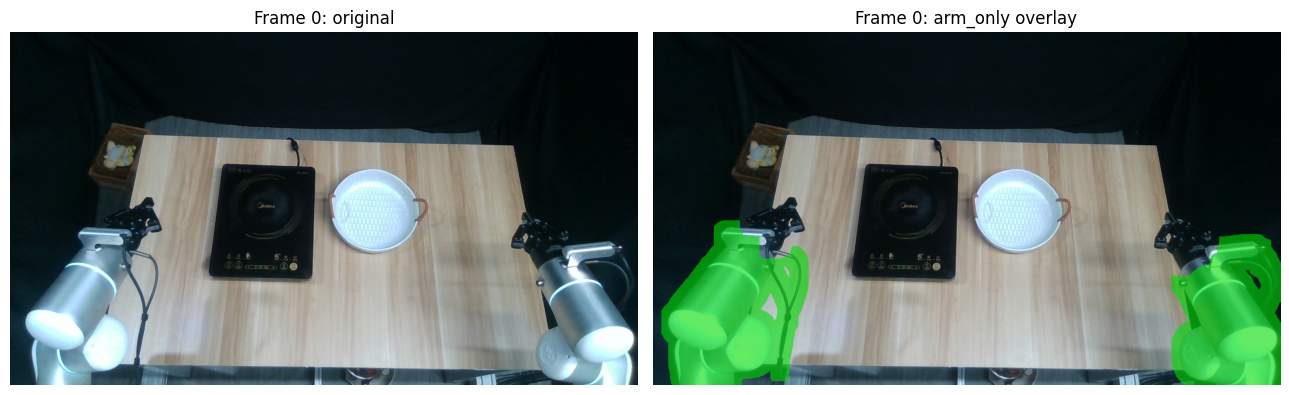

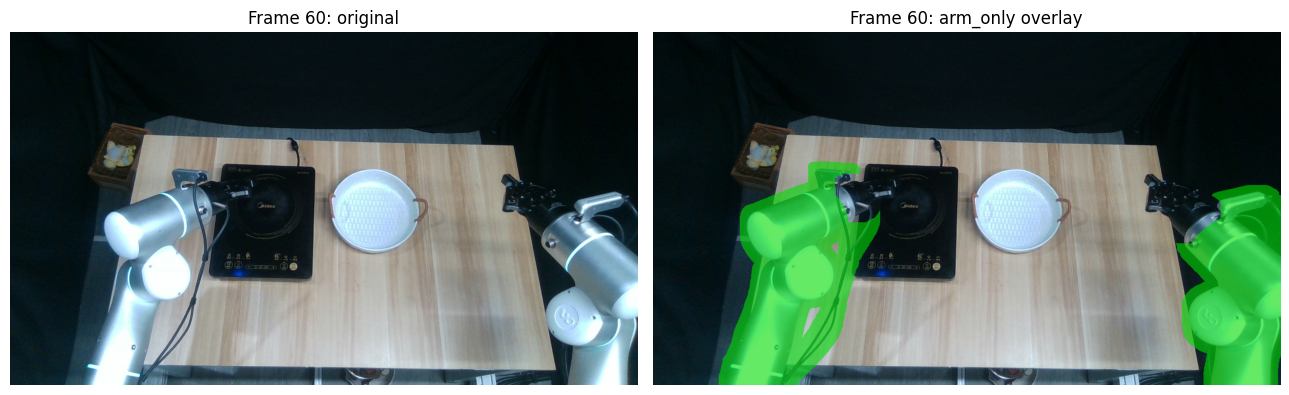

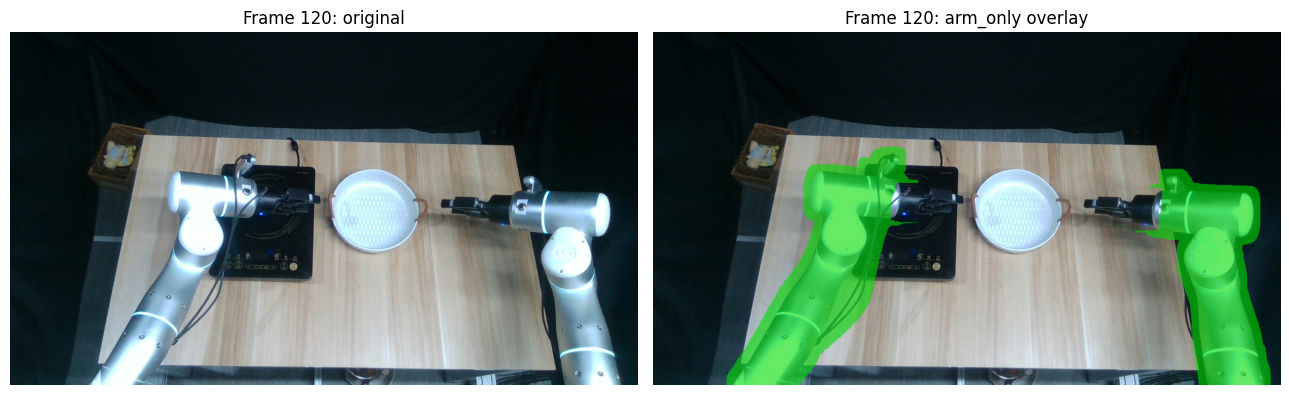

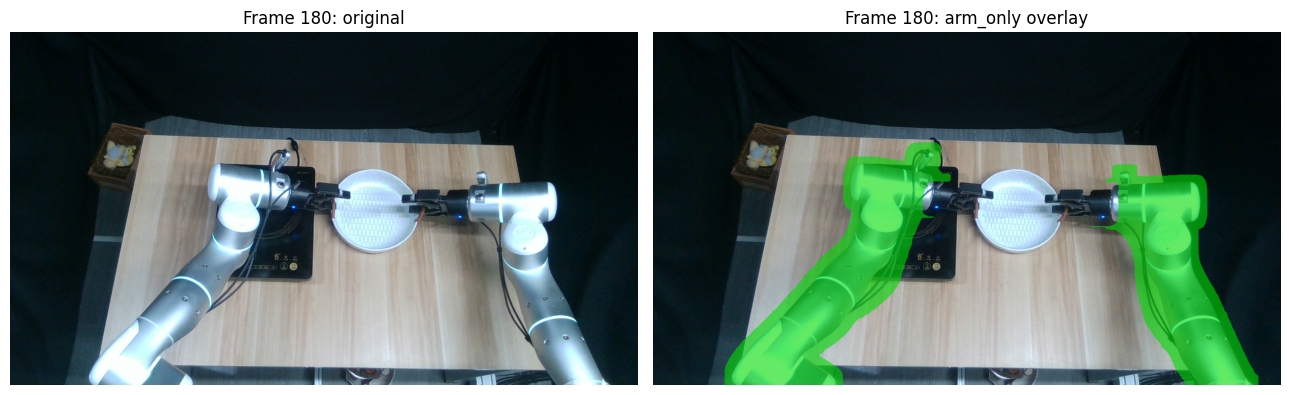

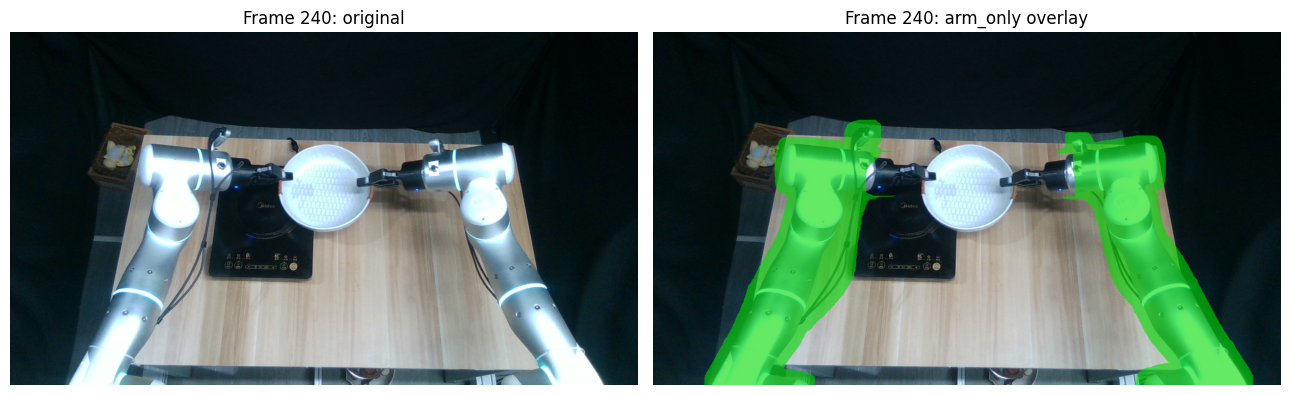

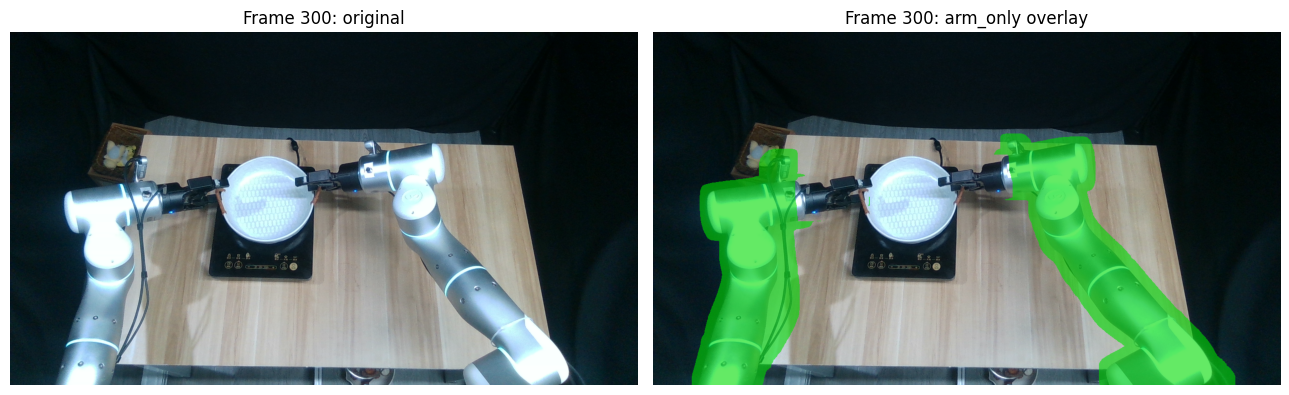

In [4]:
# Merge + 导出 arm_only 掩膜

# ============================================================
# Merge + 导出 arm_only 掩膜
# arm_only = dilated_arm AND NOT dilated_gripper（纯 NumPy，无 SAM3 依赖）
#
# arm  来源：outputs_arm  的全部 obj_ids（Session 1 只有 arm，无需过滤）
# gripper 来源：outputs_gripper 中 GRIPPER_LEFT/RIGHT_OBJ_ID（过滤掉 arm bootstrap obj_id）
# ============================================================

if outputs_arm is None or len(outputs_arm) == 0:
    raise RuntimeError("[merge] outputs_arm 为空，请先运行 Session 1 cell。")
if outputs_gripper is None or len(outputs_gripper) == 0:
    raise RuntimeError("[merge] outputs_gripper 为空，请先运行 Session 2 cell。")

# Session 1 只有 arm 对象，outputs_arm 中的全部 obj_id 均为 arm
# 收集实际出现的 arm obj_ids（仅用于日志）
_arm_obj_ids_present = set()
for _fo in outputs_arm.values():
    for _oid, _ in iter_object_masks_from_frame_output(_fo):
        _arm_obj_ids_present.add(int(_oid))

_gripper_set = set()
if gripper_left_prompts_norm and len(gripper_left_prompts_norm) > 0:
    _gripper_set.add(GRIPPER_LEFT_OBJ_ID)
if gripper_right_prompts_norm and len(gripper_right_prompts_norm) > 0:
    _gripper_set.add(GRIPPER_RIGHT_OBJ_ID)

print(f"[merge] arm  obj_ids (all used): {sorted(_arm_obj_ids_present)}")
print(f"[merge] gripper obj_ids: {sorted(_gripper_set)}")
print(f"[merge] dilate_radius={EXPORT_DILATE_RADIUS}")
print(f"[merge] output_dir={EXPORT_OUTPUT_DIR}")

os.makedirs(EXPORT_OUTPUT_DIR, exist_ok=True)

_kernel = None
if EXPORT_DILATE_RADIUS > 0:
    _ks = 2 * int(EXPORT_DILATE_RADIUS) + 1
    _kernel = np.ones((_ks, _ks), np.uint8)
    print(f"[merge] dilation kernel: {_ks}x{_ks}")

_img_w, _img_h = get_frame_size(video_frames_for_vis)
_saved_paths = []
_total_gripper_px = 0

for _frame_idx in range(TOTAL_FRAMES):
    # --- arm union：outputs_arm 全部 obj_ids（Session 1 无 gripper，全是 arm）---
    _arm_union = np.zeros((_img_h, _img_w), dtype=np.uint8)
    for _oid, _mask in iter_object_masks_from_frame_output(outputs_arm.get(_frame_idx, {})):
        if isinstance(_mask, torch.Tensor):
            _mask = _mask.detach().cpu().numpy()
        if _mask.ndim > 2:
            _mask = np.squeeze(_mask)
        _arm_union = np.maximum(_arm_union, (_mask > 0).astype(np.uint8) * 255)

    # --- gripper union：outputs_gripper 中仅 gripper obj_ids（过滤掉 arm bootstrap）---
    _gripper_union = np.zeros((_img_h, _img_w), dtype=np.uint8)
    for _oid, _mask in iter_object_masks_from_frame_output(outputs_gripper.get(_frame_idx, {})):
        if int(_oid) not in _gripper_set:
            continue
        if isinstance(_mask, torch.Tensor):
            _mask = _mask.detach().cpu().numpy()
        if _mask.ndim > 2:
            _mask = np.squeeze(_mask)
        _gripper_union = np.maximum(_gripper_union, (_mask > 0).astype(np.uint8) * 255)

    # --- 膨胀（分别处理）---
    if _kernel is not None:
        if np.any(_arm_union):
            _arm_union = cv2.dilate(_arm_union, _kernel, iterations=1)
        if np.any(_gripper_union):
            _gripper_union = cv2.dilate(_gripper_union, _kernel, iterations=1)

    # --- arm_only = arm AND NOT gripper ---
    _arm_only = np.where((_arm_union > 0) & (_gripper_union == 0), 255, 0).astype(np.uint8)

    _total_gripper_px += int(np.count_nonzero(_gripper_union))

    if _frame_idx % max(int(EXPORT_LOG_EVERY), 1) == 0 or _frame_idx == TOTAL_FRAMES - 1:
        print(
            f"[merge][frame {_frame_idx:05d}] "
            f"arm_px={int(np.count_nonzero(_arm_union))} "
            f"gripper_px={int(np.count_nonzero(_gripper_union))} "
            f"arm_only_px={int(np.count_nonzero(_arm_only))}"
        )

    _out_fp = os.path.join(EXPORT_OUTPUT_DIR, f"{_frame_idx:05d}.png")
    Image.fromarray(_arm_only, mode="L").save(_out_fp)
    _saved_paths.append(_out_fp)

if _total_gripper_px == 0:
    raise ValueError(
        "[merge][FATAL] 所有帧的 gripper 像素总和为 0。\n"
        "GRIPPER_LEFT/RIGHT_OBJ_ID 可能与 outputs_gripper 中的实际 obj_id 不一致。\n"
        "请检查 Session 2 可视化结果中显示的 obj_ids。"
    )

print(f"[merge] export complete: {len(_saved_paths)} masks → {EXPORT_OUTPUT_DIR}")

# ============================================================
# 可视化 Merge 结果（抽帧叠加检查）
# 绿色高亮 = arm_only 掩膜区域
# ============================================================

_vis_frames = list(range(0, TOTAL_FRAMES, VIS_FRAME_STRIDE))[:VIS_MAX_PLOTS]
plt.close("all")

for _fidx in _vis_frames:
    _mask_fp = os.path.join(EXPORT_OUTPUT_DIR, f"{_fidx:05d}.png")
    if not os.path.exists(_mask_fp):
        print(f"[vis/merge] mask not found: {_mask_fp}")
        continue

    _mask_img = np.array(Image.open(_mask_fp).convert("L"))
    _frame_img = video_frames_for_vis[_fidx].copy()

    _overlay = _frame_img.copy()
    _mb = _mask_img > 0
    _overlay[_mb] = (
        _frame_img[_mb] * 0.4 + np.array([0, 220, 0], dtype=np.float32) * 0.6
    ).astype(np.uint8)

    _fig, _axes = plt.subplots(1, 2, figsize=(13, 4))
    _axes[0].imshow(_frame_img)
    _axes[0].set_title(f"Frame {_fidx}: original")
    _axes[0].axis("off")
    _axes[1].imshow(_overlay)
    _axes[1].set_title(f"Frame {_fidx}: arm_only overlay")
    _axes[1].axis("off")
    plt.tight_layout()
    plt.show()

In [ ]:
# 清理

# ============================================================
# 防御性清理（重复运行或异常中断后确保资源释放）
# ============================================================

if predictor_arm is not None:
    print("[cleanup] cleaning arm predictor (not yet cleaned)")
    cleanup_resources(predictor_obj=predictor_arm, session_id_value=session_id_arm)
    predictor_arm = None
    session_id_arm = None
else:
    print("[cleanup] predictor_arm already cleaned")

if predictor_gripper is not None:
    print("[cleanup] cleaning gripper predictor (not yet cleaned)")
    cleanup_resources(predictor_obj=predictor_gripper, session_id_value=session_id_gripper)
    predictor_gripper = None
    session_id_gripper = None
else:
    print("[cleanup] predictor_gripper already cleaned")

cleanup_process_group()
print("[cleanup] all resources released")

[cleanup] predictor_arm already cleaned
[cleanup] predictor_gripper already cleaned
[cleanup] all resources released
